In [1]:
import os
os.chdir('..')

Refer to the following source for more information:
 
"Harvesting the HAR-X Volatility Model" https://papers.ssrn.com/sol3/papers.cfm?abstract_id=4733597

# Import Files

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import Parallel, delayed
from sklearn.linear_model import LinearRegression

from src.yahoo_finance import *

In [3]:
params = {
    'symbol': 'SPY',
    'start_date': '2000-01-03',
    'end_date': '2021-12-28',
    'interval': '1d'
}
yf = VolatilityYF(**params)
df = yf.pipeline()
df.head(5)

[*********************100%***********************]  1 of 1 completed


Price,date,Adj Close,Close,High,Low,Open,Volume,log_return
0,2000-01-03,91.887772,145.4375,148.25000,143.875000,148.25000,8164300,NaN
1,2000-01-04,88.294418,139.7500,144.06250,139.640625,143.53125,8089800,-0.039891
2,2000-01-05,88.452354,140.0000,141.53125,137.250000,139.93750,12177900,0.001787
3,2000-01-06,87.030769,137.7500,141.50000,137.750000,139.62500,6227200,-0.016202
4,2000-01-07,92.085228,145.7500,145.75000,140.062500,140.31250,8066500,0.056453


# Heterogeneous Autoregressive (HAR) Volatility Model
## Low Frequency Volatility Estimates
The paper introduced the following low-frequency realized volatility estimators:

**Parkinson Volatility**
$$P_t = \sqrt{\frac{1}{4log(2)}\left[log\left(\frac{h_t}{l_t}\right)\right]^2}$$

**Garman-Klass Volatility**
$$GK_t = \sqrt{\frac{1}{2}\left[log\left(\frac{h_t}{l_t}\right)\right]^2 - (2log(2) - 1)\left[log\left(\frac{c_t}{o_t}\right)\right]^2}$$

**Rogers-Satchell Volatility**
$$RS_t = \sqrt{log\left(\frac{h_t}{o_t}\right)log\left(\frac{h_t}{c_t}\right) + log\left(\frac{l_t}{o_t}\right)log\left(\frac{l_t}{c_t}\right)}$$

**Average of the Three**
$$RB_t = \frac{P_t + GK_t + RS_t}{3}$$
where $h_t$ is the high price, $l_t$ is the low price, $o_t$ is the opening price, and $c_t$ is the closing price.

**Below are my thoughts on the volatility measures**:

The high–low range provides a snapshot of the most extreme price movements within a day, which some could argue is sufficient to describe the intraday volatility. However, one could also argue that the open and close prices reveal how much of that intraday variation translates into a sustained price movement. As a result, combining high, low, open, and close prices could yield a more complete description of volatility than relying on the range alone.

Put in another way, volatility can be seen as the uncertainty of future outcomes. Let us take these two cases:
- Case A: $OHLC = (48, 51, 45, 48)$
- Case B: $OHLC = (45, 51, 45, 50)$

In both cases, the range is 6 (51-45), however both tell a different story in terms of uncertainty. Case A could indicate that there is equal buyer and seller pressure, hence future outcome is likely to be the same as today. Meanwhile, Case B has the stock closing near its highs, which indicates strong buyer pressure and uncertain future outcome. Will the stock hit higher highs? Will there be profit-taking which lead to lower lows? The future is more uncertain. Nonetheless, there is no right answer to which volatility measure to use. It could be the average of two measures, or perhaps the right measure appears only after applying a dimensionality reduction technique on all three. At the end of the day, it highly depends on your use-case and utility function.

In [4]:
class VolatilityMeasures:
    def __init__(self, df:pd.DataFrame):
        self.df = df.copy()
    
    def rogers_satchell_volatility(self, close:float, high:float, low:float, open:float) -> float:
        first_term = np.log(high/open)* np.log(high/close)
        second_term = np.log(low/open)* np.log(low/close)
        return np.sqrt(first_term + second_term)
    
    def garman_klass_volatility(self, close:float, high:float, low:float, open:float) -> float:
        first_term = 0.5* np.log(high/low)**2
        second_term = (2*np.log(2) - 1)* np.log(close/open)**2
        return np.sqrt(first_term - second_term)
    
    def parkinson_volatility(self, high:float, low:float) -> float:
        squared_log_hl = np.log(high/low)**2
        denom = 4*np.log(2)
        return np.sqrt(squared_log_hl/denom)
    
    def average_volatility(self, close:float, high:float, low:float, open:float) -> float:
        numerator = self.parkinson_volatility(high, low) + self.garman_klass_volatility(close, high, low, open) + self.rogers_satchell_volatility(close, high, low, open)
        return numerator/3
    
    def pipeline(self) -> pd.DataFrame:
        self.df['rogers_satchell'] = self.rogers_satchell_volatility(self.df['Close'], self.df['High'], self.df['Low'], self.df['Open'])
        self.df['garman_klass'] = self.garman_klass_volatility(self.df['Close'], self.df['High'], self.df['Low'], self.df['Open'])
        self.df['parkinson_volatility'] = self.parkinson_volatility(self.df['High'], self.df['Low'])
        self.df['average_volatility'] = self.average_volatility(self.df['Close'], self.df['High'], self.df['Low'], self.df['Open'])
        return self.df

In [5]:
lfv = VolatilityMeasures(df)
df = lfv.pipeline()
df.head(5)

Price,date,Adj Close,Close,High,Low,Open,Volume,log_return,rogers_satchell,garman_klass,parkinson_volatility,average_volatility
0,2000-01-03,91.887772,145.4375,148.25000,143.875000,148.25000,8164300,NaN,0.017988,0.017520,0.017990,0.017832
1,2000-01-04,88.294418,139.7500,144.06250,139.640625,143.53125,8089800,-0.039891,0.011567,0.014512,0.018723,0.014934
2,2000-01-05,88.452354,140.0000,141.53125,137.250000,139.93750,12177900,0.001787,0.022536,0.021718,0.018447,0.020901
3,2000-01-06,87.030769,137.7500,141.50000,137.750000,139.62500,6227200,-0.016202,0.018929,0.017032,0.016131,0.017364
4,2000-01-07,92.085228,145.7500,145.75000,140.062500,140.31250,8066500,0.056453,0.008425,0.015289,0.023905,0.015873


In [6]:
df.iloc[:, -4:].describe().round(3).T.loc[:, ['mean', '50%', 'min', 'max']]

,mean,50%,min,max
Price,,,,
rogers_satchell,0.008,0.006,0.000,0.087
garman_klass,0.008,0.006,0.001,0.082
parkinson_volatility,0.008,0.006,0.001,0.072
average_volatility,0.008,0.006,0.001,0.078


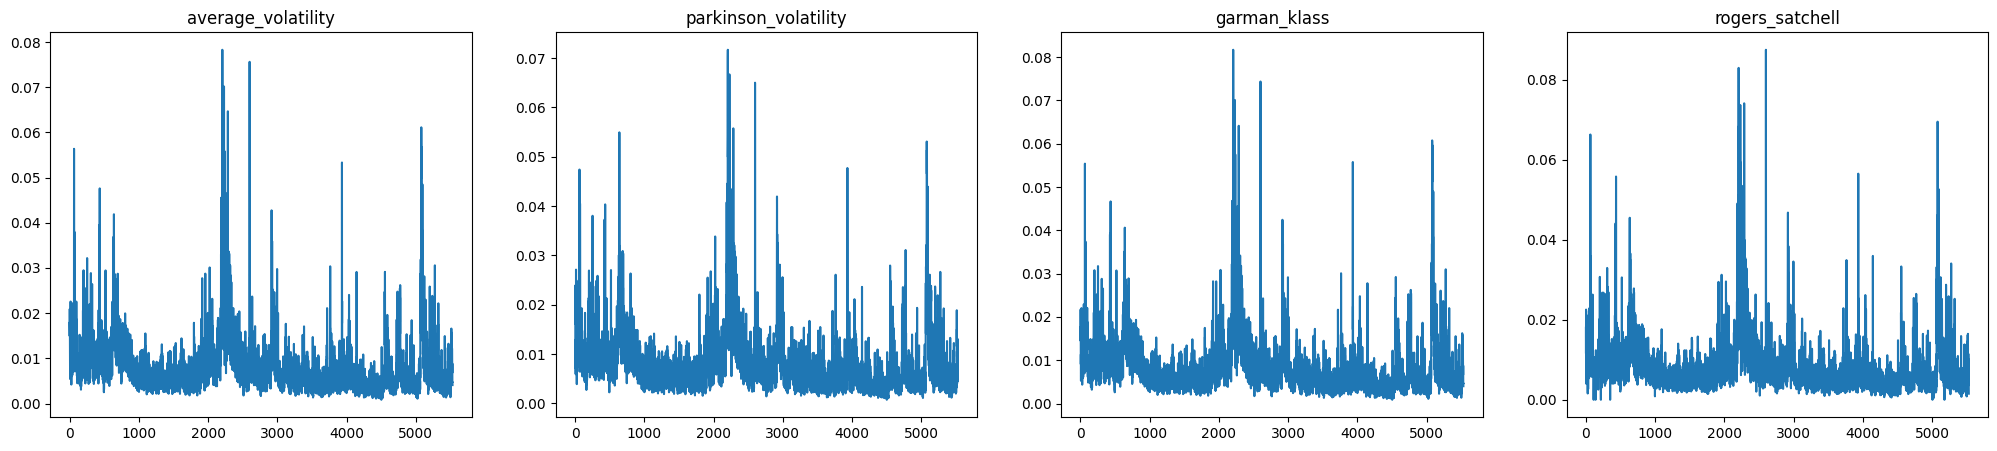

In [7]:
col_names = df.iloc[:, -4:].columns
fig, axes = plt.subplots(ncols=4, figsize=(25,5))
for i in range(1, 4+1):
    axes[i-1].plot(df.iloc[:, -i])
    axes[i-1].set_title(col_names[-i])
plt.show()

In [8]:
train_df = df.loc[df['date'] < pd.Timestamp('2019-11-17'), ['garman_klass', 'date']]
train_df.set_index('date', drop=True, inplace=True)

## Baseline HAR Model

Originally, the HAR volatility model forecasts future volatility by relying on the square root of realized variance as an estimator for latent volatility. It is denoted by:
$$RV_t = \beta_0 + \beta_1\frac{1}{W}\sum^W_{i=1}RV_{t-i} + \beta_2\frac{1}{M}\sum^M_{i=1}RV_{t-i} + \epsilon_t $$
where $W=5$ and $M=22$. However, this could change for cryptocurrency as the market also trades on weekends, hence we get $W=7$ and $M=30$.

In order to calculate the high-frequency estimator, we have the following:
$$RV_t = \sqrt{\sum^K_{k=1}r^2_{t, k}}$$
where $r_{t,k}$ represents the k-th intraday return on trading day $t$.

Through the experiments detailed on the paper, they found that we can achieve a close estimate using low-frequency realized volatility estimators and seven exogenous variables. 

We shall first start off with the OLS-HAR-GarmanKlass model denoted by:
$$GK_t = \beta_0 + \beta_1\frac{1}{W}\sum^W_{i=1}GK_{t-i} + \beta_2\frac{1}{M}\sum^M_{i=1}GK_{t-i} + \epsilon_t $$
where $W=5$ and $M=22$.

We will also follow the methodology of model training, where we fit the model on a rolling window of 1000 to predict the next step volatility. (More details can be found in the paper.) 

In [9]:
class RecursiveHAR:
    def __init__(self, volatility_measure:pd.Series, weekly:int=5, monthly:int=22):
        self.data = volatility_measure.copy()
        self.days_by_period = {
            'weekly': weekly,
            'monthly': monthly
        }
        
        self.df = self._prepare_features()
    
    def _prepare_features(self) -> pd.DataFrame:
        prev_day = self.data.shift(1)
        weekly = self.data.rolling(self.days_by_period['weekly']).mean().shift(1) #current volatility cannot rely on a rolling average using its own value 
        monthly = self.data.rolling(self.days_by_period['monthly']).mean().shift(1)
        col_names = ['volatility', 'prev_day', 'weekly_rolling_avg', 'monthly_rolling_avg']
        df = pd.concat([self.data, prev_day, weekly, monthly], axis=1)
        df.columns = col_names
        return df.dropna()
    
    def _rolling_ols(self, X:np.ndarray, y:np.ndarray, window:int=1000) -> dict:
        lr = LinearRegression(fit_intercept=True)
        preds, betas, intercepts = [], [], []
        
        for k in range(window, len(y)):
            X_train = X[k-window:k] #right side excludes k-th data point
            y_train = y[k-window:k]
            model = lr.fit(X_train, y_train)
            
            X_test = X[[k]]
            y_pred = model.predict(X_test)
            preds.append(y_pred[0])
            betas.append(model.coef_)
            intercepts.append(model.intercept_)
        
        results = {
            'preds': preds,
            'betas': betas,
            'intercepts': intercepts
        }
        
        return results
    
    def backtest(self, window:int=1000) -> pd.DataFrame:
        X = self.df.iloc[:, 1:].values
        y = self.df.iloc[:, 0].values
        results = self._rolling_ols(X, y, window)
        
        #Create Dataframe
        preds = pd.Series(results['preds'], index=self.df.index[window:], name='y_hat')
        betas = pd.DataFrame(results['betas'], index=self.df.index[window:], columns=self.df.columns[1:])
        betas = betas.add_prefix("beta_")
        intercepts = pd.Series(results['intercepts'], index=self.df.index[window:], name='intercept')
        self.eval = pd.concat([betas, intercepts, preds, self.df.iloc[window:, 0]], axis=1)
        return self.eval
    
    def fit(self, window:int=1000):
        self.window = window
        self.fitted_values = self.df.iloc[-window:, 1:]
        y = self.df.iloc[-window:, 0]
        self.model = LinearRegression(fit_intercept=True).fit(self.fitted_values.values, y.values)
    
    def _process_next_day_features(self, latest_data:np.ndarray) -> np.ndarray:
        prev_day = latest_data[-1]
        weekly = latest_data[-self.days_by_period['weekly']:].mean()
        monthly = latest_data[-self.days_by_period['monthly']:].mean()
        return np.array([[prev_day, weekly, monthly]]) #(1, 3)
    
    def forecast(self, steps:int=1) -> np.ndarray:
        if steps < 1:
            raise ValueError("Number of steps must be more than or equal to 1.")
        
        latest_data = self.data.iloc[-self.days_by_period['monthly']:].values.flatten()
        preds = []
        for _ in range(steps):
            X = self._process_next_day_features(latest_data)
            pred = self.model.predict(X)[0]
            preds.append(pred)
            
            #Update latest data
            latest_data[:-1] = latest_data[1:]
            latest_data[-1] = pred
        
        return np.array(preds)
    
    @property
    def mse(self) -> float:
        if not hasattr(self, "eval"):
            raise ValueError("Evaluate the model using .backtest() before calling this method.")
        
        squared_error = (self.eval.iloc[:, -1] - self.eval.iloc[:, -2])**2
        mse = squared_error.mean()
        return mse

In [10]:
har = RecursiveHAR(train_df)
har.fit()

print(f"Coefficients: {har.model.coef_}")
har.fitted_values.head(5)

Coefficients: [0.35523067 0.39606754 0.1101328 ]


,prev_day,weekly_rolling_avg,monthly_rolling_avg
date,,,
2015-11-27,0.002407,0.004256,0.005229
2015-11-30,0.003152,0.004311,0.005192
2015-12-01,0.003208,0.004106,0.005000
2015-12-02,0.004439,0.004024,0.005052
2015-12-03,0.006993,0.004040,0.005158


In [11]:
eval = har.backtest()
print(f"MSE: {har.mse}")
eval.head(5)

MSE: 1.5433046484905073e-05


,beta_prev_day,beta_weekly_rolling_avg,beta_monthly_rolling_avg,intercept,y_hat,volatility
date,,,,,,
2004-01-29,0.045549,0.510652,0.299441,0.001545,0.007919,0.008046
2004-01-30,0.045105,0.511716,0.298933,0.001545,0.008187,0.003922
2004-02-02,0.044880,0.511661,0.301424,0.001520,0.007506,0.009572
2004-02-03,0.042835,0.514716,0.300182,0.001530,0.008314,0.004344
2004-02-04,0.040863,0.514081,0.304473,0.001514,0.007534,0.005563


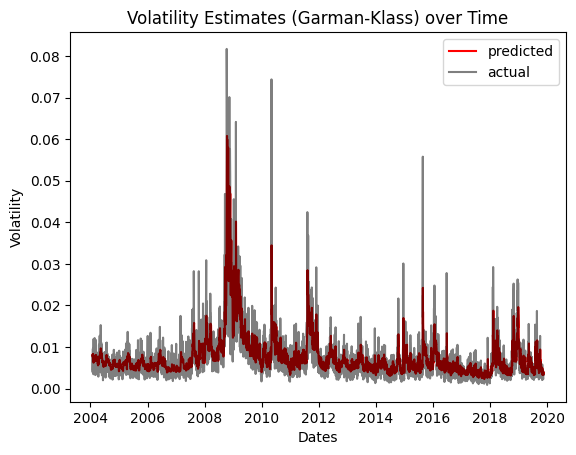

In [12]:
plt.plot(har.eval['y_hat'], color='red', label='predicted')
plt.plot(har.eval['volatility'], color='black', alpha=0.5, label='actual')
plt.title("Volatility Estimates (Garman-Klass) over Time") 
plt.ylabel("Volatility")
plt.xlabel("Dates")
plt.legend()
plt.show()

In [13]:
har.forecast(5)

array([0.00360686, 0.00384196, 0.00389086, 0.00393863, 0.00401668])

## Optimize HAR

Since each training window is independent of the results from the others, we can parallelize that code. 

This requires us to separate the worker function and reduce object copying overhead by slicing NumPy arrays instead of Pandas Dataframe. For safety reasons, we will use "n_jobs=-2".

Based on the processing time, we do not see any improvement. On the contrary, the computational efficiency got slower. This is likely due to the small number of features and each task is small at 1000 observations, hence the fixed costs dominate.

In [ ]:
class OptimizedRecursiveHAR(RecursiveHAR):
    def __init__(self, volatility_measure:pd.Series, weekly:int=5, monthly:int=22):
        super().__init__(volatility_measure, weekly, monthly)
    
    @staticmethod
    def _fit_predict(X_window, y_window, X_test_row) -> tuple[float, np.ndarray, float]:
        model = LinearRegression().fit(X_window, y_window)
        return model.predict(X_test_row)[0], model.coef_, model.intercept_
    
    def _rolling_ols(self, X:np.ndarray, y:np.ndarray, window:int) -> dict:
        results = Parallel(n_jobs=-2)(
            delayed(OptimizedRecursiveHAR._fit_predict)(
                X[k - window:k],
                y[k - window:k],
                X[[k]]
            )
            for k in range(window, len(y))
        )
        preds, betas, intercepts = zip(*results)
        
        results = {
            'preds': preds,
            'betas': betas,
            'intercepts': intercepts
        }
        
        return results

In [15]:
o_har = OptimizedRecursiveHAR(df['garman_klass'])
o_eval = o_har.backtest()
o_eval.head(5)

,beta_prev_day,beta_weekly_rolling_avg,beta_monthly_rolling_avg,intercept,y_hat,volatility
1022,0.045549,0.510652,0.299441,0.001545,0.007919,0.008046
1023,0.045105,0.511716,0.298933,0.001545,0.008187,0.003922
1024,0.044880,0.511661,0.301424,0.001520,0.007506,0.009572
1025,0.042835,0.514716,0.300182,0.001530,0.008314,0.004344
1026,0.040863,0.514081,0.304473,0.001514,0.007534,0.005563


## Paper's HAR Model

After checking my results with the forecast results from their Shiny app: https://daniel-preve.shinyapps.io/LF_HAR-X/

I realized that my implementation of the forecast methodology is different from what was written. In this section, we will amend the HAR model to be aligned with the paper.

In [219]:
class DirectHAR(RecursiveHAR):
    def __init__(self, volatility_measure:pd.Series, weekly:int=5, monthly:int=22):
        super().__init__(volatility_measure, weekly, monthly)
    
    def _build_target(self, horizon:int) -> pd.Series:
        """Redefine the dependent variable as the future h-average volatility"""
        if horizon < 1:
            raise ValueError("Horizon must be more than or equal to 1.")
        
        new_target = self.data.rolling(horizon).mean()
        new_target = new_target.shift(-horizon+1) #Use the data today, to predict the average h-day future volatility
        return new_target.dropna()
    
    def backtest(self, horizon:int, window:int=1000) -> pd.DataFrame:
        target = self._build_target(horizon=horizon)
        df = self.df.iloc[:, 1:].join(target, how="inner") #Align Index
        
        X = df.iloc[:, :-1]
        y = df.iloc[:, -1]
        y.name = 'target'
        results = self._rolling_ols(X.values, y.values, window)
        
        #Create Dataframe
        betas = pd.DataFrame(results['betas'], index=X.index[window:], columns=X.columns).add_prefix("beta_")
        intercepts = pd.Series(results['intercepts'], index=X.index[window:], name='intercept')
        preds = pd.Series(results['preds'], index=X.index[window:], name='y_hat')
        self.eval = pd.concat([betas, intercepts, preds, y.iloc[window:]], axis=1)
        return self.eval
    
    def fit(self, horizon:int, window:int=1000):
        self.window = window
        
        #Filter only for what we need
        start_pt = -window+1-horizon
        X = self.df.iloc[start_pt:-horizon+1, 1:] if horizon > 1 else self.df.iloc[start_pt:, 1:]
        y = self._build_target(horizon).iloc[-window:]
        y.columns = ['target']
        self.fitted_values = pd.concat([X, y], axis=1)
        
        self.model = LinearRegression(fit_intercept=True).fit(X.values, y.values)
    
    def forecast(self) -> np.ndarray[float]:
        """Uses the latest data and the fitted regressors to predict the next h-day average volatility."""
        X = self.df.iloc[[-1], 1:].values
        pred = self.model.predict(X)[0]
        return pred

In [222]:
d_har = DirectHAR(train_df)
d_har.fit(horizon=5)
d_har.fitted_values.head(5)

,prev_day,weekly_rolling_avg,monthly_rolling_avg,target
date,,,,
2015-11-20,0.002879,0.005637,0.005483,0.004311
2015-11-23,0.004233,0.005399,0.005441,0.004106
2015-11-24,0.004847,0.004997,0.005177,0.004024
2015-11-25,0.006917,0.004931,0.005238,0.004040
2015-11-27,0.002407,0.004256,0.005229,0.005863


In [223]:
d_har.forecast()

array([0.0038556])

In [202]:
d_eval = d_har.backtest(horizon=5)
print(f"MSE: {d_har.mse}")
d_eval.head(5)

MSE: 8.085855298902904e-06


,beta_prev_day,beta_weekly_rolling_avg,beta_monthly_rolling_avg,intercept,y_hat,target
date,,,,,,
2004-01-29,0.064247,0.492331,0.247246,0.002107,0.008233,0.006289
2004-01-30,0.061288,0.497769,0.246364,0.002093,0.008411,0.005630
2004-02-02,0.060806,0.499071,0.247426,0.002076,0.007691,0.006330
2004-02-03,0.060203,0.499621,0.248434,0.002068,0.008549,0.005101
2004-02-04,0.059391,0.498773,0.251419,0.002052,0.007690,0.005124


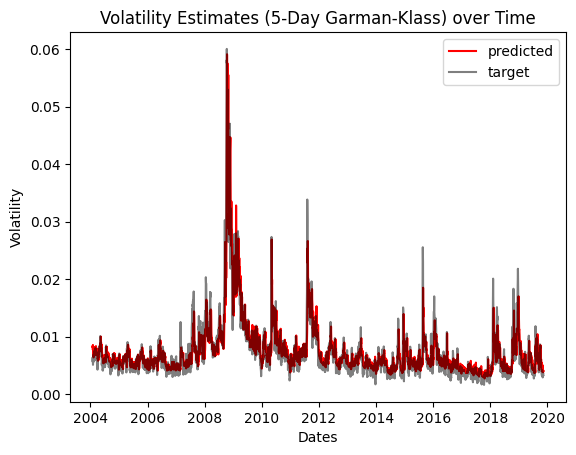

In [203]:
plt.plot(d_har.eval['y_hat'], color='red', label='predicted')
plt.plot(d_har.eval['target'], color='black', alpha=0.5, label='target')
plt.title("Volatility Estimates (5-Day Garman-Klass) over Time") 
plt.ylabel("Volatility")
plt.xlabel("Dates")
plt.legend()
plt.show()

# HAR-X Model
## Exogenous Variables